## Imports

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

from scipy.optimize import minimize

## Sum of squares

In [2]:
def sum_of_squares_error(y: pd.Series,w: np.array, ph: pd.DataFrame, regularized: bool = True, lamb: float = 0.1) -> float:
    """Calculates the sum of squares error function

    Parameters
    ----------
    y : pd.Series
        target variable
    w : np.array
        current weights
    ph : pd.DataFrame
        phi function evaluated for every entry of X
    regularized : bool, optional
        Includes weight decay regularization to avoid overfitting, by default True
    lamb : float, optional
        Regularization parameter, by default 0.1
        
    Returns
    -------
    float
        Sum of squared error
    """
    res = 0
    wt = np.array([w])
    ph_np = ph.to_numpy()
    for i,val in y.items():
        ph_i = ph_np[i].reshape(-1,1)
        res = res + (0.5*(val - np.matmul(wt,ph_i))**2)[0][0]
        if regularized:
            res = res + (0.5*lamb*np.matmul(wt,w))[0] 
    return res

In [3]:
def sose_for_min(w :np.array,*args: Tuple[pd.Series, pd.DataFrame, bool, float]) -> float:
    """Calls the funcion sum_of_squares_error in the format apropriate for minimization with scipy

    Parameters
    ----------
    w : np.array
        Initial weigths
    *args: Tuple[pd.Series, pd.DataFrame, bool, float]
        pd.Series: target data
        pd.DataFrame: phi functions evaluated at X
        bool: Include weight decay regularization. Default 
        float: value of we
        
    Returns
    -------
    float
        Sum of squares error
    """
    y = args[0]
    ph = args[1]
    if len(args) > 2:
        regularized = args[2]
    else:
        regularized = True
    
    if len(args) > 3:
        lamb = args[3]
    else:
        lamb = 0.1
    return sum_of_squares_error(y, w, ph, regularized=regularized, lamb=lamb)

## Min max scaling

In [4]:
def min_max_scaling(ds: pd.Series) -> Tuple[pd.Series, Tuple[float,float]]:
    """Linearly scales a pandas series from min -> max to 0 -> 1

    Parameters
    ----------
    ds : pd.Series
        Series to scale

    Returns
    -------
    Tuple[pd.Series, Tuple[float,float]]
        pd.Series: Scaled Series
        Tuple[float,float]
            float: Minimum of the original series
            float: Maximum of the original series
    """
    mx = np.nanmax(ds)
    mn = np.nanmin(ds)
    delta = mx - mn
    ds_out = (ds - mn)/delta
    return ds_out, (mn,mx)

## Metrics

In [5]:
def r_squared(y_orig: np.array, y_pred: np.array):
    """Calculates the R squared of a target and predicted arrays

    Parameters
    ----------
    y_orig : np.array
        Target array
    y_pred : np.array
        Predicted array

    Returns
    -------
    _type_
        R squared
    """
    ssreg = np.nansum(np.power(y_orig - y_pred,2))
    sstot = np.nansum(np.power(y_orig - np.nanmean(y_pred),2))
    Rsqrd = 1 - ssreg/sstot
    return Rsqrd

## Linear regression

In [18]:
class LinearRegression:
    def __init__(self) -> None:
        self.w = None
        self.ph = None

    def fit(self, X: pd.DataFrame, y: pd.Series, bias: float = 0, basis_function: str  = 'lineal', w: np.array = None,
            regularized: bool = True, lamb: float = 0.1):
        """fit X data towards y target using Linear regression

        Parameters
        ----------
        X : pd.DataFrame
            Independent data
        y : pd.Series
            Target data
        bias : float, optional
            Constant vertical shift, by default 0
        basis_function : str, optional
            Basis functions Phi of the linear regressor, by default 'lineal'
                'lineal': Phi = X
                'sigmoid': Phi = Logistic Sigmoidal function
                other values: Phi = 1
        w : np.array, optional
            Initial guess of the weights, by default all ones
        regularized : bool, optional
            Includes weight decay regularization to avoid overfitting, by default True
        lamb : float, optional
            Regularization parameter, by default 0.1                       
        """
        if w is None:
            w = np.ones(X.shape[1])
        match basis_function:
            case 'lineal':
                self.ph = X
            case 'sigmoid':
                X_mean = X.mean(axis=0)
                a = (X - X_mean).to_numpy()
                self.ph = pd.DataFrame(1/(1 + np.exp(-a)), columns=X.columns)
            case _:
                self.ph = pd.DataFrame(np.ones(X.shape), columns=X.columns)

        res = minimize(sose_for_min, w, args=(y, self.ph, regularized, lamb))
        self.w = res.x

    def predict(self, X: pd.DataFrame):
        y_trained = self.ph.apply(lambda x: np.nansum(x.to_numpy()*self.w),axis = 1)
        return y_trained

In [7]:
df = pd.read_csv('../data/1.raw/electricityConsumptionAndProductioction.csv', parse_dates=['DateTime'])
X_cols = ['Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
y_col = 'Production'

X = df[X_cols]
for c in X.columns:
    X[c] = min_max_scaling(X[c])[0]

y = df[y_col]
y = min_max_scaling(y)[0]

C:\Users\an2fe\AppData\Local\Temp\ipykernel_12868\1746569770.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = min_max_scaling(X[c])[0]


In [19]:
lg = LinearRegression()
lg.fit(X,y,basis_function='sigmoid', regularized=False)

y_predict = lg.predict(X)
r_squared(y,y_predict)

In [20]:
lg_l = LinearRegression()
lg_l.fit(X,y,basis_function='lineal', regularized=False)

y_predict_l = lg_l.predict(X)
r_squared(y,y_predict_l)

0.9047521661040017

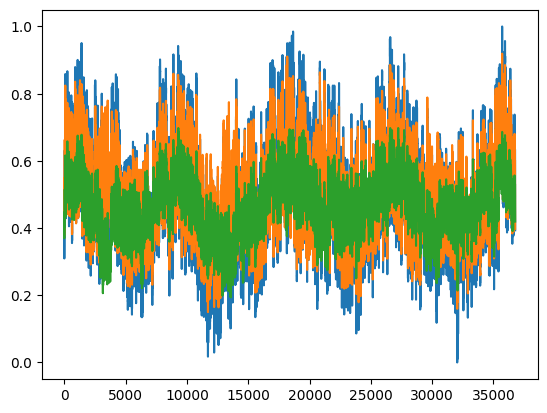

In [22]:
plt.plot(y)
plt.plot(y_predict_l)
plt.plot(y_predict)
plt.show()

In [17]:

sigm

array([[0.53000279, 0.43804468, 0.4750087 , ..., 0.55228401, 0.4565186 ,
        0.40019335],
       [0.52941316, 0.43952029, 0.45888825, ..., 0.54097981, 0.4565186 ,
        0.40019335],
       [0.52941316, 0.44351839, 0.45402583, ..., 0.53822925, 0.4565186 ,
        0.40019335],
       ...,
       [0.5332442 , 0.43457704, 0.56748698, ..., 0.47355899, 0.4565186 ,
        0.51150914],
       [0.5332442 , 0.43189399, 0.56072863, ..., 0.47024796, 0.4565186 ,
        0.50798936],
       [0.53236044, 0.43120224, 0.54115886, ..., 0.47344858, 0.4565186 ,
        0.5044688 ]])